# ECM-MPT Data Analysis

 The following notebook will go through prediction analysis for the Extracellular-Matrix Multiple Particle Tracking (ECM-MPT) study of pup age in P14, P21, P28, and P35 datasets.


## Table of Contents


  [1.   Load Data](#1.-load-data)<br />
  [2.   Analysis](#2.-analysis)<br />
  [3.   Modelling](#modelling)<br />
  [4.   Evaluate Results](#evaluate-results)<br />

---

## 1.   Load Data

Loading feature dataset from ECM_CSVS folder: p14, p21, p28, data are designated with their repective age while p35 data is designated with NT_brain_2.

There are 15 total videos from each age group.

In [1]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as pl


from os import listdir, getcwd
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

import shap

In [2]:
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('Using Dir for loading: ' + workbookDir)
os.chdir(workbookDir) # Go to current workbook Dir
os.chdir('..')        # Go up one

Using Dir for loading: C:\Users\david\Documents\nancework\source\diff_predictor\notebooks


In [3]:
dataset_path = workbookDir + '/..' + '/raw_data_age/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]

In [103]:
fstats_tot = None
video_num = 0
for filename in filelist:
    try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1
    except Exception:
            print('Skipped!: {}'.format(filename))

features_NT_brain_2_slice_1_vid_1.csv size: (416, 91)
features_NT_brain_2_slice_1_vid_2.csv size: (833, 91)
features_NT_brain_2_slice_1_vid_3.csv size: (1017, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_NT_brain_2_slice_1_vid_5.csv size: (467, 91)
features_NT_brain_2_slice_2_vid_1.csv size: (2488, 91)
features_NT_brain_2_slice_2_vid_2.csv size: (2322, 91)
features_NT_brain_2_slice_2_vid_3.csv size: (1735, 91)
features_NT_brain_2_slice_2_vid_4.csv size: (1650, 91)
features_NT_brain_2_slice_2_vid_5.csv size: (2100, 91)
features_NT_brain_2_slice_3_vid_1.csv size: (562, 91)
features_NT_brain_2_slice_3_vid_2.csv size: (853, 91)
features_NT_brain_2_slice_3_vid_3.csv size: (817, 91)
features_NT_brain_2_slice_3_vid_4.csv size: (598, 91)
features_NT_brain_2_slice_3_vid_5.csv size: (1062, 91)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P14_40nm_s1_v4.csv size: (140, 91)
featur

In [104]:
fstats_tot.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age,Video Number
0,0.0,0.445227,16.493781,5.457711,0.900742,0.161642,0.301680,2.104323,0.524788,0.040769,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
1,1.0,0.107756,0.316246,3.334612,0.071551,0.760212,0.009322,1.213024,0.175614,0.096920,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
2,2.0,0.046968,0.440548,2.587983,0.054303,0.788683,0.007003,1.087747,0.080668,0.098123,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
3,3.0,1.759901,2.452218,2.516403,0.984714,0.062057,0.494242,3.654338,0.726353,0.105210,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
4,4.0,0.438945,8.270880,2.176721,0.997136,0.026778,0.596387,5.244316,0.809317,0.227229,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0


## 2.   Analysis

The following columns are present within the downloaded datasets:

In [105]:
fstats_tot.columns

Index(['Track_ID', 'alpha', 'D_fit', 'kurtosis', 'asymmetry1', 'asymmetry2',
       'asymmetry3', 'AR', 'elongation', 'boundedness', 'fractal_dim',
       'trappedness', 'efficiency', 'straightness', 'MSD_ratio', 'frames', 'X',
       'Y', 'Quality', 'Mean_Intensity', 'SN_Ratio', 'Deff1', 'Deff2',
       'angle_mean', 'angle_mag_mean', 'angle_var', 'convex_hull',
       'convex_hull_norm', 'dist_tot', 'dist_net', 'progression', 'Mean alpha',
       'Std alpha', 'Mean D_fit', 'Std D_fit', 'Mean kurtosis', 'Std kurtosis',
       'Mean asymmetry1', 'Std asymmetry1', 'Mean asymmetry2',
       'Std asymmetry2', 'Mean asymmetry3', 'Std asymmetry3', 'Mean AR',
       'Std AR', 'Mean elongation', 'Std elongation', 'Mean boundedness',
       'Std boundedness', 'Mean fractal_dim', 'Std fractal_dim',
       'Mean trappedness', 'Std trappedness', 'Mean efficiency',
       'Std efficiency', 'Mean straightness', 'Std straightness',
       'Mean MSD_ratio', 'Std MSD_ratio', 'Mean frames', 'Std frames

Many of these features are not useful for prediction or have data which may negatively impact classification. The following features and the target feature are defined in the following cell. We also remove any datapoints that are empty or infinite:

In [147]:
fstats_tot
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    'angle_mag_mean', # Magnitude of the turning angle mean
    'angle_var', # Variance of the turning angle
    'dist_tot', # Total distance of the trajectory
    'dist_net', # Net distance from first point to last point
    'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'           # prediction target (y)

ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points


In [148]:
# Showing a piece of our data:
ecm.head()

,Track_ID,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,...,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,age,Video Number
0,0.0,0.445227,16.493781,5.457711,0.900742,0.161642,0.301680,2.104323,0.524788,0.040769,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
1,1.0,0.107756,0.316246,3.334612,0.071551,0.760212,0.009322,1.213024,0.175614,0.096920,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
2,2.0,0.046968,0.440548,2.587983,0.054303,0.788683,0.007003,1.087747,0.080668,0.098123,...,0.0,0.0,69929.668778,50752.744606,1793.547419,1.447172,0.053308,0.044553,35,0
3,3.0,1.759901,2.452218,2.516403,0.984714,0.062057,0.494242,3.654338,0.726353,0.105210,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0
4,4.0,0.438945,8.270880,2.176721,0.997136,0.026778,0.596387,5.244316,0.809317,0.227229,...,0.0,0.0,53446.037923,39383.730785,2193.565956,17.904650,0.065281,0.040573,35,0


Before prediction, it is required to balance data. As shown, The current dataset is highly imbalance with most datapoints belonging to P21 and P35 categories. The dataset is reduced using random sampling of each target category.

In [149]:
#--------------NOT-ADDED-----------------------------
def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

Ratio before data balance (35:14:21:28) = 17169:6416:20665:6194
Ratio after balance (35:14:21:28) = 6194:6194:6194:6194


In [150]:
# ecm_14 = ecm[ecm[target] == 14]
# ecm_21 = ecm[ecm[target] == 21]
# ecm_28 = ecm[ecm[target] == 28]
# ecm_35 = ecm[ecm[target] == 35]
# print(f"Ratio before data balance (P14:P21:P28:P35) = {len(ecm_14)}:{len(ecm_21)}:{len(ecm_28)}:{len(ecm_35)}")
# ecm_list = [ecm_14, ecm_21, ecm_28, ecm_35]
# for i in range(len(ecm_list)):
#     ratio = min([len(i) for i in ecm_list])/len(ecm_list[i])
#     ecm_list[i] = ecm_list[i].sample(frac=ratio, random_state=1)
# print(f"Ratio after balance (P14:P21:P28:P35) = {len(ecm_list[0])}:{len(ecm_list[1])}:{len(ecm_list[2])}:{len(ecm_list[3])}")
# bal_ecm = pd.concat(ecm_list)

## 3.   Modelling

The model used for this study is a random forest decision tree which is a bagging decision tree. 

Due to the use of statistical surroundings in our feature analysis, binning is required in order to avoid data leakage between training/testing. The followingcode will implement binning and a checkerboard implementation to select certain bins for the training dataset.

In [151]:
# Using checkerboard binning for data split:
# def checkerboard(size):
#     rows = int(size/2)
#     checks = list(range(0, size*size, size+1))
#     for i in range(1, rows):
#         ssize = size - 2*i
#         for j in range(0, ssize):
#             checks.append(2*i + (size+1)*j)
#     for i in range(1, rows):
#         ssize = size - 2*i
#         for j in range(0, ssize):
#             checks.append(size*size - 1 - (2*i + (size+1)*j))
#     checks.sort()
#     return checks

In [152]:
# Old method
# bins = list(range(0, 2048+1, 256))
# bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7], include_lowest=True)
# bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=[0, 1, 2, 3, 4, 5, 6, 7], include_lowest=True)
# bal_ecm['bins'] = 8*bal_ecm['binx'].astype(np.int8) + bal_ecm['biny'].astype(np.int8)
# bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
# bal_ecm['bins'] = bal_ecm['bins'].astype(int)

# cols = bal_ecm.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# bal_ecm = bal_ecm[cols]

In [153]:
# def bin_data(data, ):
#     pass

resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=bin_labels, include_lowest=True)
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)

# cols = bal_ecm.columns.tolist()
# cols = cols[-3:] + cols[:-3]
# bal_ecm = bal_ecm[cols]

In [154]:
# Checkerboard method
# seed = 1234
# np.random.seed(seed)
# test_val_split = 0.5

# le = preprocessing.LabelEncoder()
# bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])
# X_train = bal_ecm[~bal_ecm.bins.isin(checkerboard((len(bins)-1)))].reset_index()
# X_test_val =  bal_ecm[bal_ecm.bins.isin(checkerboard((len(bins)-1)))].reset_index()
# y_train = X_train['encoded_target']
# X_val, X_test = train_test_split(X_test_val, test_size=test_val_split, random_state=seed)
# y_test = X_test['encoded_target']
# y_val = X_val['encoded_target']
# dtrain = xgb.DMatrix(X_train[features], label=y_train)
# dtest = xgb.DMatrix(X_test[features], label=y_test)
# dval = xgb.DMatrix(X_val[features], label=y_val)

In [156]:
# Regular split
from sklearn.model_selection import train_test_split
def split_data(df, train_split, test_val_split=1.0, seed=1234, transform=True):
    np.random.seed(seed)
    le = preprocessing.LabelEncoder()
    df['encoded_target'] = le.fit_transform(df[target])
    training_bins = np.random.choice(df.bins.unique(), int(len(df.bins.unique())*train_split), replace=False)
    X_train = df[df.bins.isin(training_bins)]
    X_test_val = df[~df.bins.isin(training_bins)]
    result = []
    if test_val_split == 1.0:
        X_test = X_test_val
    else:
        X_val, X_test = train_test_split(X_test_val, test_size=test_val_split, random_state=seed)
        y_val = X_val['encoded_target']
        result = [(X_val, y_val)]
    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    result = np.append([(X_train, y_train), (X_test, y_test)], result)
    return result
[X_train, y_train, X_test, y_test, X_val, y_val] = split_data(bal_ecm, 0.5, 0.5)

In [159]:
X_train[features] = X_train[features].fillna(-1)
X_test[features] = X_test[features].fillna(-1)
X_val[features] = X_val[features].fillna(-1)

In [160]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 24776
Training: 12482 (0.504%)
Testing: 6147 (0.248%)
Evaluation: 6147 (0.248%)


Model parameters are based on the best possible RF parameters to minimize logloss error.

In [161]:
# from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# model = XGBClassifier()

In [162]:
# model.predict(X_test[features])

In [163]:
features

['alpha',
 'D_fit',
 'kurtosis',
 'asymmetry1',
 'asymmetry2',
 'asymmetry3',
 'AR',
 'elongation',
 'boundedness',
 'fractal_dim',
 'trappedness',
 'efficiency',
 'straightness',
 'MSD_ratio',
 'frames',
 'Deff1',
 'Deff2',
 'angle_mean',
 'angle_mag_mean',
 'angle_var',
 'dist_tot',
 'dist_net',
 'progression',
 'Mean alpha',
 'Mean D_fit',
 'Mean kurtosis',
 'Mean asymmetry1',
 'Mean asymmetry2',
 'Mean asymmetry3',
 'Mean AR',
 'Mean elongation',
 'Mean boundedness',
 'Mean fractal_dim',
 'Mean trappedness',
 'Mean efficiency',
 'Mean straightness',
 'Mean MSD_ratio',
 'Mean Deff1',
 'Mean Deff2']

In [164]:
X_train[features]

,alpha,D_fit,kurtosis,asymmetry1,asymmetry2,asymmetry3,AR,elongation,boundedness,fractal_dim,...,Mean AR,Mean elongation,Mean boundedness,Mean fractal_dim,Mean trappedness,Mean efficiency,Mean straightness,Mean MSD_ratio,Mean Deff1,Mean Deff2
6882,0.058700,4.872178,2.230741,0.934611,0.130018,0.351489,2.649743,0.622605,0.200512,2.620558,...,2.524645,0.539117,0.067948,1.988796,-0.206592,0.182369,0.067046,1.103068,1.950066,0.111697
1035,0.499482,17.791992,2.367025,0.747081,0.269753,0.180774,1.638290,0.389607,0.098356,2.292443,...,2.505562,0.508342,0.084886,1.708462,-0.201727,0.723077,0.185638,0.409821,15.217692,-1.000000
3280,0.319865,0.178128,2.228540,0.924241,0.140332,0.334305,2.443060,0.590677,0.205353,1.503041,...,2.352834,0.470033,0.171660,2.089350,-0.175647,0.646677,0.215031,4.346592,1.739435,-1.000000
16311,1.033051,2.752277,4.077196,0.595927,0.358736,0.118076,1.104961,0.094991,0.153263,2.077424,...,2.612885,0.401180,0.093790,1.715901,-0.198870,1.190374,0.279910,0.023903,5.479002,-1.000000
10353,0.117586,8.113189,3.868187,0.952468,0.110336,0.387144,2.005946,0.501482,0.062994,2.190577,...,2.111080,0.473760,0.126055,1.979965,-0.189343,0.368361,0.145379,1.172096,2.129673,0.199057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49809,4.020596,0.031589,3.817871,0.933871,0.130777,0.350191,2.933550,0.659116,0.085050,1.205195,...,2.776748,0.546625,0.050239,1.434658,-0.211903,1.439908,0.363502,0.111882,17.745312,-1.000000
50646,0.149495,30.508539,2.111461,0.720085,0.286204,0.167227,1.041189,0.039560,0.162744,1.961016,...,1.041189,0.039560,0.162744,1.961016,-0.178124,0.289851,0.161446,0.415343,2.542658,-1.000000
48432,0.545460,17.918180,1.948183,0.577732,0.369199,0.112191,1.346118,0.257123,0.119320,1.511209,...,2.007850,0.469233,0.137305,1.582645,-0.185892,1.038590,0.293737,0.434234,20.831388,-1.000000
49534,0.121933,15.905727,1.965660,0.070444,0.761913,0.009172,1.221799,0.181534,0.179660,2.326421,...,2.219036,0.387853,0.135436,1.771838,-0.186318,0.605233,0.258617,0.238524,3.848835,-1.000000


In [165]:
def bin_fold(X_train, nfold):
    index = [X_train[X_train['bins'] == i_bin].index.to_numpy() for i_bin in X_train.bins.unique()]
    bin_list = []
    for ind in index:
        bin_list.append([X_train.index.get_loc(i) for i in ind])
    bin_list = sorted(bin_list, key=len)
    i = 0
    while(len(bin_list) > nfold):
        if (i >= len(bin_list)-1):
            i = 0
        bin_list[i] = np.concatenate([bin_list[i], bin_list.pop()])
        i += 1
    wt_list = [len(i)/sum(len(s) for s in bin_list) for i in bin_list]
    return bin_list, wt_list

In [174]:
from sklearn.model_selection import RandomizedSearchCV
seed = 1234
nfold = 5
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)
test_set, wt = bin_fold(X_train, nfold)
train_set = [np.concatenate([test_set[i] for i in range(nfold) if k != i]) for k in range(nfold)]
cv = zip(train_set, test_set)
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(1, 110, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15, 20]
min_samples_leaf = [1, 2, 4, 5, 6]
bootstrap = [False]
oob_score = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'oob_score': oob_score}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = cv, verbose=2, random_state=seed, n_jobs = -1)
rf_random.fit(X_train[features], y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 64.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 93.6min finished


RandomizedSearchCV(cv=<zip object at 0x0000025CDB6C6288>,
                   estimator=RandomForestClassifier(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [1, 6, 12, 18, 23, 29, 35,
                                                      41, 46, 52, 58, 64, 69,
                                                      75, 81, 87, 92, 98, 104,
                                                      110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4, 5, 6],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [200, 328, 457, 585,
                                                         714, 842, 971, 1100,
                                                         1228, 1357, 1485, 1614,
                               

In [74]:
import numpy as np
np.random.seed(123)
gs_params = {'subsample': np.random.choice([i/10. for i in range(5,11)], 3),
            'colsample': np.random.choice([i/10. for i in range(5,11)], 3),
            'eta': np.random.choice([.005, .01, .05, .1, .2, .3], 3),
            'gamma': [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3)),
            'max_depth': [10] + list(np.random.randint(1, 10, 3)),
            'min_child_weight': [0, 10] + list(np.random.randint(0, 10, 3))
            }
test2 = {
            (eta, gamma)
            for eta in gs_params['eta']
            for gamma in gs_params['gamma']
        }

In [90]:
d1 = {'hello': 1,
     'bye': 0}
d2 = {'later': 3,
     'hello': 2}
d2.update(d1)
d2

{'later': 3, 'hello': 1, 'bye': 0}

In [83]:
np.random.seed(123)
test =  {
            (eta, gamma)
            for eta in np.random.choice([.005, .01, .05, .1, .2, .3], 3)
            for gamma in [0] + list(np.random.choice([0.01, 0.001, 0.2, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0], 3))
        }

In [84]:
test2

{(0.01, 0),
 (0.01, 0.001),
 (0.01, 0.01),
 (0.01, 3.0),
 (0.05, 0),
 (0.05, 0.001),
 (0.05, 0.01),
 (0.05, 3.0),
 (0.1, 0),
 (0.1, 0.001),
 (0.1, 0.01),
 (0.1, 3.0)}

In [85]:
test

{(0.05, 0),
 (0.05, 0.001),
 (0.05, 0.5),
 (0.05, 3.0),
 (0.2, 0),
 (0.2, 0.001),
 (0.2, 0.01),
 (0.3, 0),
 (0.3, 0.001),
 (0.3, 0.2),
 (0.3, 3.0)}

In [192]:
acc = []

for i in range(50):
    df = bal_ecm
    test_val_split = 0.5
    train_split = 0.5
    seed = 1234
    np.random.seed(seed)
    le = preprocessing.LabelEncoder()
    df['encoded_target'] = le.fit_transform(df[target])
    training_bins = np.random.choice(df.bins.unique(), int(len(df.bins.unique())*train_split), replace=False)
    X_train = df[df.bins.isin(training_bins)]
    X_test_val = df[~df.bins.isin(training_bins)]
    result = []
    seed += i
    if test_val_split == 1.0:
        X_test = test_val_split
    else:
        X_val, X_test = train_test_split(X_test_val, test_size=test_val_split, random_state=seed)
        y_val = X_val['encoded_target']

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    X_train[features] = X_train[features].fillna(-1)
    X_test[features] = X_test[features].fillna(-1)
    X_val[features] = X_val[features].fillna(-1)
    ypred1 = test.predict(X_test[features])
    acc.append(metrics.accuracy_score(np.array(y_test), ypred1))
acc = np.array(acc)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [195]:
rf_random.best_params_

{'oob_score': False,
 'n_estimators': 1100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 6,
 'bootstrap': False}

In [194]:
acc.mean()

0.5320253782332844

In [182]:
ypred1 = test.predict(X_test[features])

In [189]:

print("Accuracy:",metrics.accuracy_score(np.array(y_test), ypred1))

Accuracy: 0.5296892793232472


In [26]:
cv(param, X_train, y_train, features, num_boost_round=10, nfold=5, early_stopping_rounds=3, metrics={'mlogloss', 'merror'})

,train-merror-mean,train-merror-std,train-mlogloss-mean,train-mlogloss-std,test-merror-mean,test-merror-std,test-mlogloss-mean,test-mlogloss-std
0,0.489166,0.000196,1.384513,3.997613e-09,0.545265,0.000546,1.384870,1.117922e-08
1,0.470496,0.000166,1.382821,9.581945e-09,0.540218,0.000242,1.383465,2.608192e-08
2,0.469108,0.000276,1.381121,5.873459e-09,0.527319,0.000327,1.382025,5.246235e-08
3,0.467118,0.000050,1.379486,3.499019e-09,0.526999,0.000213,1.380690,1.189785e-07
4,0.462674,0.000036,1.377819,2.146799e-08,0.521871,0.000085,1.379350,1.632066e-07
5,0.463222,0.000034,1.376222,3.586439e-08,0.523153,0.000288,1.378049,2.470692e-07
6,0.459195,0.000064,1.374504,6.300012e-08,0.520990,0.000236,1.376670,4.288491e-07
7,0.460282,0.000075,1.372836,8.809238e-08,0.522592,0.000336,1.375355,5.718858e-07
8,0.460317,0.000036,1.371197,1.190338e-07,0.521230,0.000320,1.374047,7.599153e-07
9,0.458222,0.000062,1.369597,1.369024e-07,0.522592,0.000459,1.372783,8.114502e-07


In [49]:
evals = [(dtrain, 'train'), (dval, 'eval')]
num_round = best_boost_rounds
bst = xgb.train(best_param, dtrain, num_round, evals, early_stopping_rounds=3, )


######
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]

print("Accuracy:",metrics.accuracy_score(y_test, pred))


NameError: name 'best_boost_rounds' is not defined

In [18]:
bst = xgb.Booster({'nthread':4})

In [111]:
from datetime import date
import json
bst.save_model(f'model_xgboost_P14_P21_P28_P32_50-50-split_{str(date.today())}')
with open(f'config_xgboost_P14_P21_P28_P32_50-50-split_{str(date.today())}', 'w', encoding='utf-8') as f:
    json.dump(bst.save_config(), f, ensure_ascii=False, indent=4)

In [19]:
from datetime import date
import json
bst.load_model(f'model_xgboost_P14_P21_P28_P32_50-50-split_2020-07-18')
with open(f'config_xgboost_P14_P21_P28_P32_50-50-split_2020-07-18', 'r', encoding='utf-8') as f:
    config = f.read()
    config = json.loads(config)
setting = bst.load_config(config)

In [20]:
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]

print("Accuracy:",metrics.accuracy_score(y_test, pred))

Accuracy: 0.5510004880429478


In [21]:
model_bytearray = bst.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
bst.save_raw = myfun

In [22]:
# import ctypes

# def c_array(ctype, values):
#     """Convert a python string to c array."""
#     if (isinstance(values, np.ndarray)
#             and values.dtype.itemsize == ctypes.sizeof(ctype)):
#         return (ctype * len(values)).from_buffer_copy(values)
#     return (ctype * len(values))(*values)

# mats = c_array(ctypes.c_void_p, [dtrain.handle])


In [23]:
# tst = X_test[features + [target]]
# tst['tst'] = y_test

In [24]:
results = X_test[features]
results['predicted'] = pred
results['actual'] = y_test


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 4.   Evaluate Results

In [25]:
# print('0 == {}'.format(le.inverse_transform([0])))
# print('1 == {}'.format(le.inverse_transform([1])))
# print('2 == {}'.format(le.inverse_transform([2])))
# print('3 == {}'.format(le.inverse_transform([3])))
class_names = ['P14', 'P21', 'P28', 'P35']
class_results = classification_report(y_test, pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.6733    0.7749    0.7206      1524
         P21     0.4737    0.5250    0.4980      1543
         P28     0.4825    0.3124    0.3793      1546
         P35     0.5428    0.5952    0.5678      1534

    accuracy                         0.5510      6147
   macro avg     0.5431    0.5519    0.5414      6147
weighted avg     0.5426    0.5510    0.5407      6147



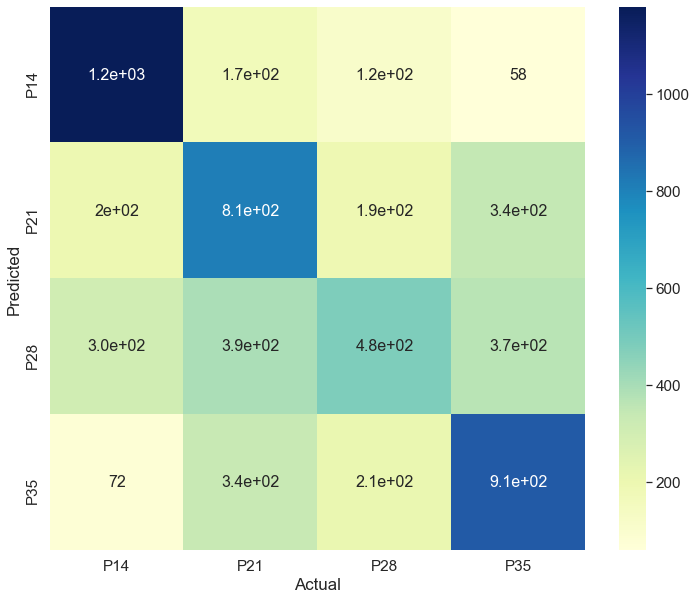

In [26]:
confusion_matrix(y_test, pred)
pl.figure(figsize=(12,10))
cm_array = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sn.set(font_scale=1.4) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Actual', ylabel='Predicted')

pl.show()

In [27]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_test[features])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [28]:
%matplotlib inline

In [29]:
colors = ['#999999', '#e5bf62', '#7995e9', '#a64ca6']
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

In [30]:
# sn.reset_orig() # Reset matplot lib to no longer use seaborn

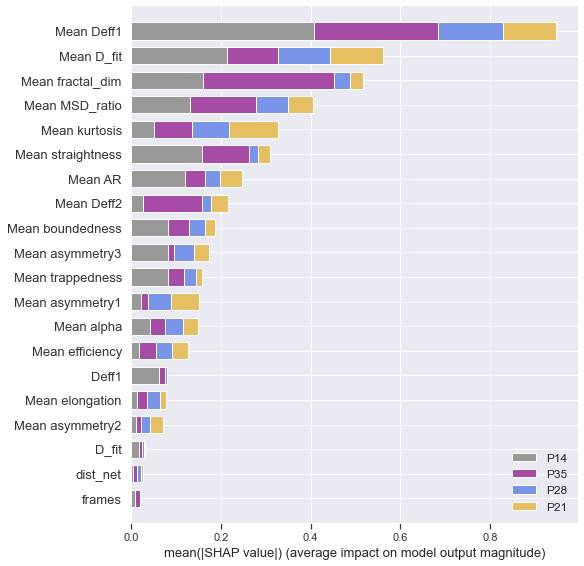

In [31]:
shap.summary_plot(shap_values, X_test[features], class_names=np.array(class_names), title='Total SHAP Values', color=cmap)

In [1]:
X_test['Deff1']

NameError: name 'X_test' is not defined

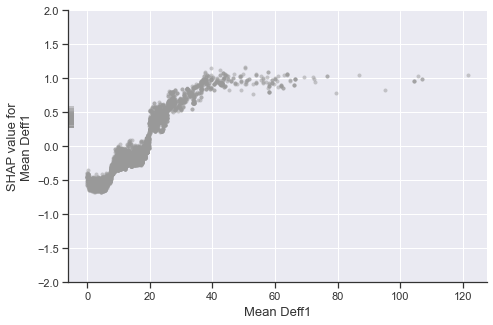

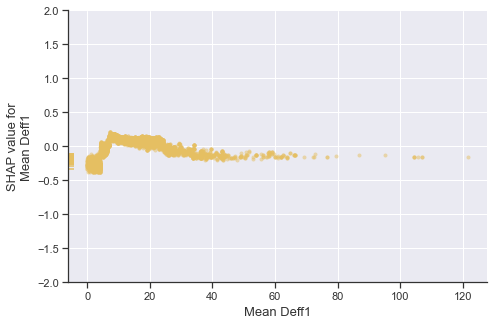

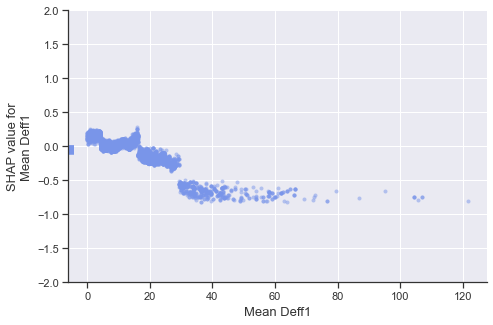

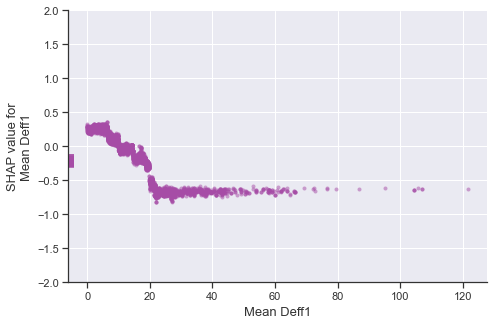

In [32]:
pl.ioff()
%matplotlib inline

figsize = (7.5, 5)
bottom = -2.0
top = 2.0
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean Deff1", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

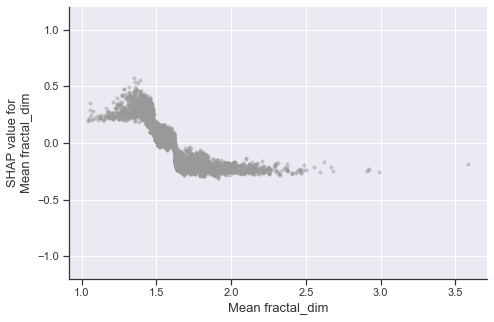

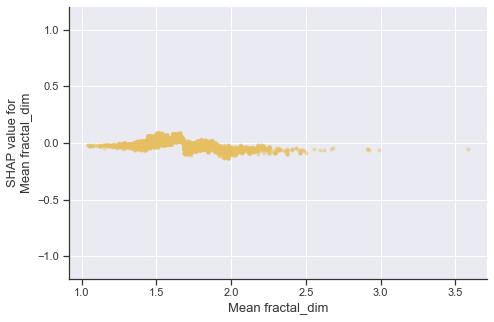

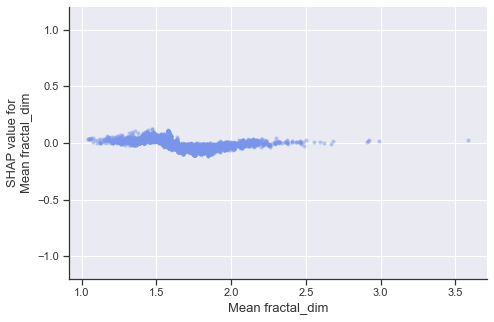

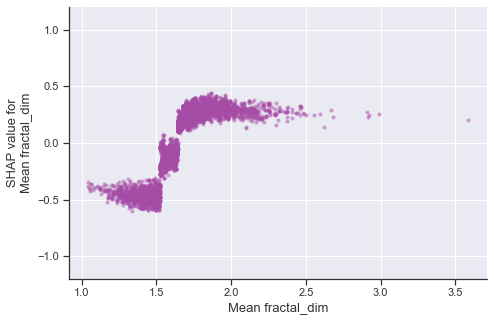

In [33]:
figsize = (7.5, 5)
bottom = -1.2
top = 1.2
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean fractal_dim", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

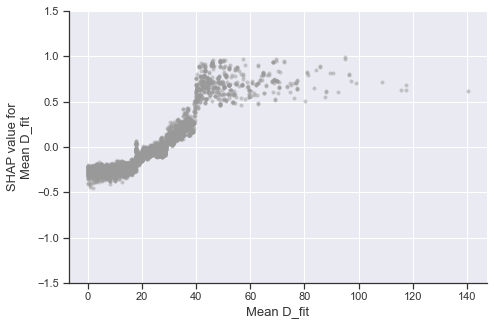

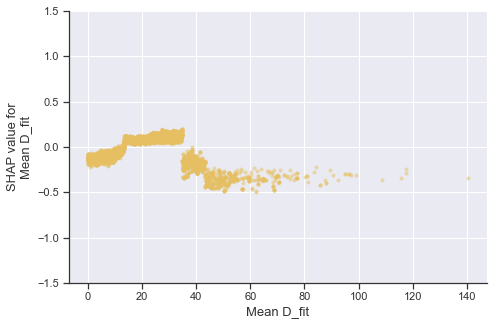

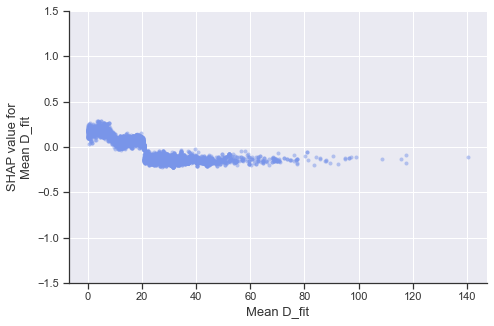

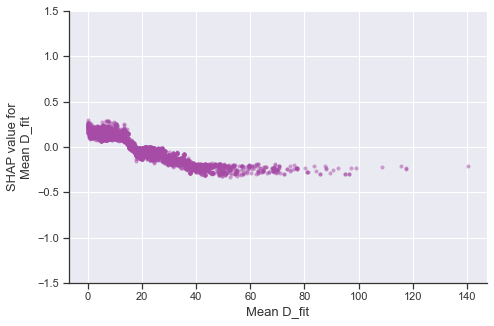

In [34]:
figsize = (7.5, 5)
bottom = -1.5
top = 1.5
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean D_fit", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

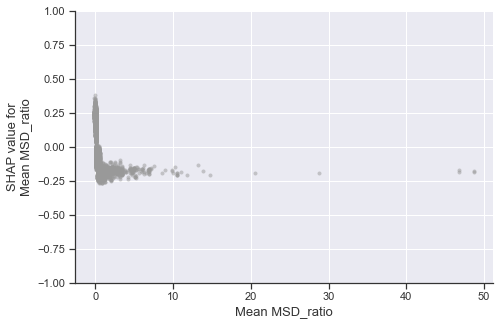

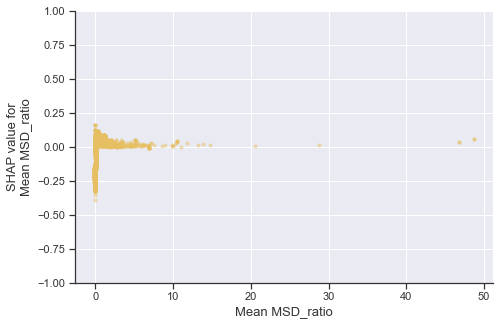

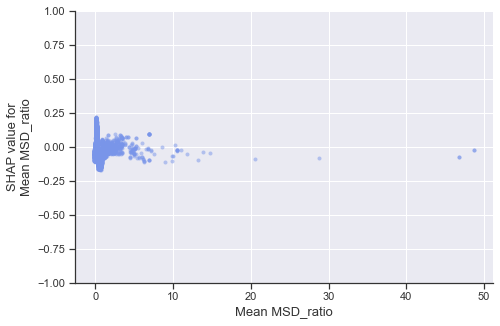

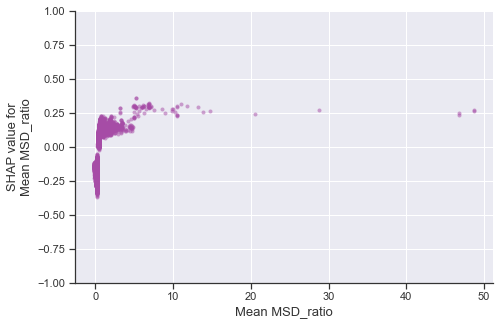

In [35]:
figsize = (7.5, 5)
bottom = -1.0
top = 1.0
for i in range(len(shap_values)):
    fig = pl.figure(figsize=figsize)
    ax = fig.gca()
    ax.set_ylim(bottom, top)
    shap.dependence_plot("Mean MSD_ratio", shap_values[i], X_test[features], interaction_index = None, color=colors[i], alpha=0.5, ax=ax)

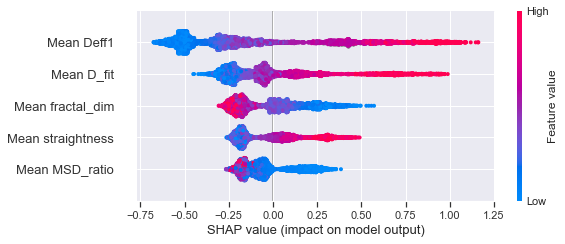

In [36]:
shap.summary_plot(shap_values[0], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P14')

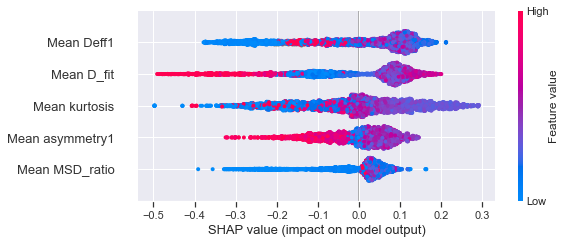

In [36]:
shap.summary_plot(shap_values[1], X_test[features], max_display=5, class_names = class_names, title = 'SHAP Value for P21')

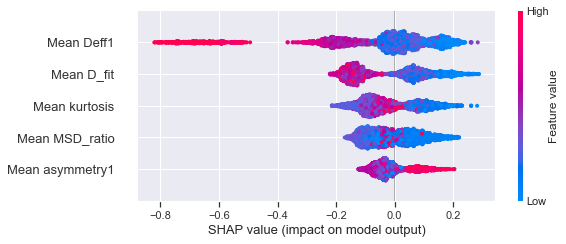

In [37]:
shap.summary_plot(shap_values[2], X_test[features], max_display=5, class_names = class_names, title='SHAP Value for P28')

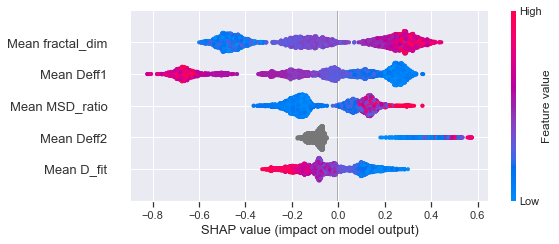

In [38]:
shap.summary_plot(shap_values[3], X_test[features], max_display=5, class_names=class_names, title='SHAP Value for P35')

In [279]:
from modules import anim_plot_changed
from importlib import reload
reload(anim_plot_changed)

_ = anim_plot_changed.rotate_3d(results, [top_feat[0], top_feat[1], top_feat[2]])
_ = anim_plot_changed.rotate_3d(results, [top_feat[0], top_feat[2], top_feat[3]])
_ = anim_plot_changed.rotate_3d(results, [top_feat[1], top_feat[2], top_feat[3]])

ImportError: cannot import name 'anim_plot_changed' from 'modules' (unknown location)

In [280]:
from modules import anim_plot_changed
from importlib import reload
reload(anim_plot_changed)

_ = anim_plot_changed.rotate_3d(results, [top_feat[0], top_feat[1], top_feat[2]], anim_param={'frames':np.arange(0,720,1)}, save_param={'filename':'This_is_a_test.gif','fps':50})

ImportError: cannot import name 'anim_plot_changed' from 'modules' (unknown location)

In [281]:
from matplotlib import animation
from matplotlib.animation import PillowWriter

In [286]:
from sklearn import model

ImportError: cannot import name 'model' from 'sklearn' (C:\ProgramData\Miniconda3\lib\site-packages\sklearn\__init__.py)

In [288]:
print(model.feature_importances_)

NameError: name 'model' is not defined

In [283]:
# Feature search (new) -------not in file--------: 
import operator
from sklearn.metrics import accuracy_score

def feature_thresholding_helper(X_train, X_test, X_val, new_feat):
    dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
    dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
    dval = xgb.DMatrix(X_val[new_feat], label=y_val)
    return dtrain, dtest, dval

def feature_thresholding(X_train, y_train, X_test, y_test, X_val, y_val, params, features, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mlogloss', 'merror'}, thresh=np.arange(0,.1,.002)):
    best_thresh = -1
    if params['eval_metric'] in ['map', 'auc', 'aucpr']:
        best_eval = -np.inf
        eval_f = operator.gt
    else: 
        best_eval = np.inf
        eval_f = operator.lt
    
    best_eval = -np.inf
    eval_f = operator.gt
    
    for t in thresh:
        print(f"Using thresh = {t} ",end = '| ')
        new_feat = list(np.array(features)[np.array(model.feature_importances_ > t)])

#         cv_model = cv(params, 
#                       X_train, 
#                       y_train, 
#                       features=new_feat, 
#                       nfold=nfold, 
#                       num_boost_round=num_boost_round, 
#                       early_stopping_rounds=early_stopping_rounds, 
#                       metrics=metrics) 
#         cv_eval = cv_model[f"test-{'merror'}-mean"].min()
#         print(f"Eval = {cv_eval} ", end = '| ')
#         if eval_f(cv_eval, best_eval):
#             best_thresh = t
#             best_eval = cv_eval

        dtrain, dtest, dval = feature_thresholding_helper(X_train, X_test, X_val, new_feat)
        evals = [(dtrain, 'train'), (dval, 'eval')]
        bst2 = xgb.train(best_param, dtrain, 1500, evals, early_stopping_rounds=3, verbose_eval=False)
        ######
        label = dtest.get_label()
        ypred1 = bst2.predict(dtest)
        # by default, we predict using all the trees
        pred2 = [np.where(x == np.max(x))[0][0] for x in ypred1]

        cv_eval = accuracy_score(y_test, pred2)
        if eval_f(cv_eval, best_eval):
            best_thresh = t
            best_eval = cv_eval
            
        print(f"Best eval = {best_eval}, Best threshold = {best_thresh}")
    print(f"Features used:\n{np.array(features)[np.array(model.feature_importances_ > best_thresh)]}")
    return list(np.array(features)[np.array(model.feature_importances_ > best_thresh)])

new_feat = feature_thresholding(X_train, y_train, X_test, y_test, X_val, y_val, best_param, features)

Using thresh = 0.0 | 

NameError: name 'model' is not defined

In [362]:
new_feat = list(np.array(features)[np.array(model.feature_importances_ > best_thresh)])

In [371]:
cv_model = cv(best_param, 
              X_train, 
              y_train, 
              features=new_feat, 
              nfold=5, 
              num_boost_round=best_boost_rounds, 
              early_stopping_rounds=3, 
              metrics={'mlogloss', 'merror'}) 
cv_model

In [374]:
dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
dval = xgb.DMatrix(X_val[new_feat], label=y_val)

In [375]:
evals = [(dtrain, 'train'), (dval, 'eval')]
num_round = best_boost_rounds
bst = xgb.train(best_param, dtrain, num_round, evals, early_stopping_rounds=3, )


######
label = dtest.get_label()
ypred1 = bst.predict(dtest)
# by default, we predict using all the trees
pred = [np.where(x == np.max(x))[0][0] for x in ypred1]

[0]	train-mlogloss:1.38480	eval-mlogloss:1.38538
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.38298	eval-mlogloss:1.38424
[2]	train-mlogloss:1.38080	eval-mlogloss:1.38266
[3]	train-mlogloss:1.37877	eval-mlogloss:1.38131
[4]	train-mlogloss:1.37662	eval-mlogloss:1.37985
[5]	train-mlogloss:1.37462	eval-mlogloss:1.37853
[6]	train-mlogloss:1.37239	eval-mlogloss:1.37699
[7]	train-mlogloss:1.37065	eval-mlogloss:1.37585
[8]	train-mlogloss:1.36888	eval-mlogloss:1.37481
[9]	train-mlogloss:1.36682	eval-mlogloss:1.37343
[10]	train-mlogloss:1.36465	eval-mlogloss:1.37196
[11]	train-mlogloss:1.36287	eval-mlogloss:1.37079
[12]	train-mlogloss:1.36106	eval-mlogloss:1.36964
[13]	train-mlogloss:1.35940	eval-mlogloss:1.36858
[14]	train-mlogloss:1.35725	eval-mlogloss:1.36707
[15]	train-mlogloss:1.35526	eval-mlogloss:1.36570
[16]	train-mlogloss:1.35396	eval-mlogloss:1.36495
[17]	train

[160]	train-mlogloss:1.15536	eval-mlogloss:1.24018
[161]	train-mlogloss:1.15457	eval-mlogloss:1.23980
[162]	train-mlogloss:1.15354	eval-mlogloss:1.23918
[163]	train-mlogloss:1.15256	eval-mlogloss:1.23870
[164]	train-mlogloss:1.15174	eval-mlogloss:1.23827
[165]	train-mlogloss:1.15069	eval-mlogloss:1.23765
[166]	train-mlogloss:1.14976	eval-mlogloss:1.23721
[167]	train-mlogloss:1.14871	eval-mlogloss:1.23654
[168]	train-mlogloss:1.14776	eval-mlogloss:1.23597
[169]	train-mlogloss:1.14668	eval-mlogloss:1.23530
[170]	train-mlogloss:1.14568	eval-mlogloss:1.23474
[171]	train-mlogloss:1.14480	eval-mlogloss:1.23432
[172]	train-mlogloss:1.14380	eval-mlogloss:1.23378
[173]	train-mlogloss:1.14274	eval-mlogloss:1.23314
[174]	train-mlogloss:1.14192	eval-mlogloss:1.23272
[175]	train-mlogloss:1.14083	eval-mlogloss:1.23220
[176]	train-mlogloss:1.13996	eval-mlogloss:1.23166
[177]	train-mlogloss:1.13914	eval-mlogloss:1.23123
[178]	train-mlogloss:1.13832	eval-mlogloss:1.23083
[179]	train-mlogloss:1.13733	ev

[321]	train-mlogloss:1.03255	eval-mlogloss:1.17763
[322]	train-mlogloss:1.03186	eval-mlogloss:1.17733
[323]	train-mlogloss:1.03137	eval-mlogloss:1.17713
[324]	train-mlogloss:1.03072	eval-mlogloss:1.17685
[325]	train-mlogloss:1.03011	eval-mlogloss:1.17658
[326]	train-mlogloss:1.02961	eval-mlogloss:1.17643
[327]	train-mlogloss:1.02913	eval-mlogloss:1.17623
[328]	train-mlogloss:1.02854	eval-mlogloss:1.17595
[329]	train-mlogloss:1.02801	eval-mlogloss:1.17577
[330]	train-mlogloss:1.02746	eval-mlogloss:1.17553
[331]	train-mlogloss:1.02690	eval-mlogloss:1.17528
[332]	train-mlogloss:1.02638	eval-mlogloss:1.17507
[333]	train-mlogloss:1.02576	eval-mlogloss:1.17486
[334]	train-mlogloss:1.02526	eval-mlogloss:1.17467
[335]	train-mlogloss:1.02464	eval-mlogloss:1.17441
[336]	train-mlogloss:1.02399	eval-mlogloss:1.17416
[337]	train-mlogloss:1.02350	eval-mlogloss:1.17396
[338]	train-mlogloss:1.02295	eval-mlogloss:1.17370
[339]	train-mlogloss:1.02237	eval-mlogloss:1.17345
[340]	train-mlogloss:1.02175	ev

[482]	train-mlogloss:0.95478	eval-mlogloss:1.14879
[483]	train-mlogloss:0.95443	eval-mlogloss:1.14865
[484]	train-mlogloss:0.95396	eval-mlogloss:1.14853
[485]	train-mlogloss:0.95364	eval-mlogloss:1.14845
[486]	train-mlogloss:0.95325	eval-mlogloss:1.14830
[487]	train-mlogloss:0.95290	eval-mlogloss:1.14822
[488]	train-mlogloss:0.95249	eval-mlogloss:1.14813
[489]	train-mlogloss:0.95208	eval-mlogloss:1.14798
[490]	train-mlogloss:0.95167	eval-mlogloss:1.14789
[491]	train-mlogloss:0.95124	eval-mlogloss:1.14773
[492]	train-mlogloss:0.95081	eval-mlogloss:1.14760
[493]	train-mlogloss:0.95042	eval-mlogloss:1.14750
[494]	train-mlogloss:0.95006	eval-mlogloss:1.14736
[495]	train-mlogloss:0.94961	eval-mlogloss:1.14720
[496]	train-mlogloss:0.94926	eval-mlogloss:1.14714
[497]	train-mlogloss:0.94885	eval-mlogloss:1.14701
[498]	train-mlogloss:0.94841	eval-mlogloss:1.14687
[499]	train-mlogloss:0.94798	eval-mlogloss:1.14674
[500]	train-mlogloss:0.94759	eval-mlogloss:1.14656
[501]	train-mlogloss:0.94715	ev

[643]	train-mlogloss:0.90179	eval-mlogloss:1.13538
[644]	train-mlogloss:0.90152	eval-mlogloss:1.13526
[645]	train-mlogloss:0.90119	eval-mlogloss:1.13516
[646]	train-mlogloss:0.90094	eval-mlogloss:1.13507
[647]	train-mlogloss:0.90069	eval-mlogloss:1.13499
[648]	train-mlogloss:0.90046	eval-mlogloss:1.13493
[649]	train-mlogloss:0.90016	eval-mlogloss:1.13489
[650]	train-mlogloss:0.89983	eval-mlogloss:1.13481
[651]	train-mlogloss:0.89959	eval-mlogloss:1.13476
[652]	train-mlogloss:0.89935	eval-mlogloss:1.13473
[653]	train-mlogloss:0.89914	eval-mlogloss:1.13468
[654]	train-mlogloss:0.89889	eval-mlogloss:1.13463
[655]	train-mlogloss:0.89863	eval-mlogloss:1.13463
[656]	train-mlogloss:0.89845	eval-mlogloss:1.13461
[657]	train-mlogloss:0.89817	eval-mlogloss:1.13458
[658]	train-mlogloss:0.89783	eval-mlogloss:1.13455
[659]	train-mlogloss:0.89757	eval-mlogloss:1.13451
[660]	train-mlogloss:0.89726	eval-mlogloss:1.13443
[661]	train-mlogloss:0.89701	eval-mlogloss:1.13442
[662]	train-mlogloss:0.89673	ev

In [376]:
# print('0 == {}'.format(le.inverse_transform([0])))
# print('1 == {}'.format(le.inverse_transform([1])))
# print('2 == {}'.format(le.inverse_transform([2])))
# print('3 == {}'.format(le.inverse_transform([3])))
class_names = ['P14', 'P21', 'P28', 'P35']
class_results = classification_report(y_test, pred, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.6306    0.7071    0.6667       898
         P21     0.4256    0.5091    0.4636       876
         P28     0.3953    0.2662    0.3181       943
         P35     0.5202    0.5352    0.5276       938

    accuracy                         0.5018      3655
   macro avg     0.4929    0.5044    0.4940      3655
weighted avg     0.4924    0.5018    0.4924      3655



In [327]:
# Running CV with newly thresholded features; using new seed of 123 to get different unique GS hyperparams
best_model2, best_param2, best_eval2, best_boost_rounds2 = xgb_paramsearch(X_train, y_train, new_feat, init_params=best_param, nfold=5, num_boost_round=2000, early_stopping_rounds=3, metrics={'mlogloss', 'merror'}, use_gpu='True', seed=123)

Using CV with subsample={0.7}, colsample_bytree={0.7}
New best param found: mlogloss = {1.05563476842045}, boost_rounds = {1116}
Using CV with subsample={0.7}, colsample_bytree={0.8}
Using CV with subsample={0.7}, colsample_bytree={0.6}
Using CV with subsample={0.9}, colsample_bytree={0.6}
Using CV with subsample={0.9}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={0.8}
Using CV with subsample={1.0}, colsample_bytree={0.7}
Using CV with subsample={1.0}, colsample_bytree={0.6}
Using CV with max_depth={1}, min_child_weight={2}
Using CV with max_depth={4}, min_child_weight={10}
Using CV with max_depth={4}, min_child_weight={7}
Using CV with max_depth={1}, min_child_weight={3}
Using CV with max_depth={10}, min_child_weight={4}
Using CV with max_depth={10}, min_child_weight={10}
Using CV with max_depth={4}, min_child_weight={4}
Using CV with max_depth={1}, min_child_weight={4}
Using CV with max_depth={1}, min_child_weight={7}
Using CV with max_depth={1}, min_child_

Using CV with max_depth={10}, min_child_weight={0}
Using CV with max_depth={10}, min_child_weight={9}
Using CV with max_depth={10}, min_child_weight={2}
Using CV with eta={0.3}, gamma={1.0}
Using CV with eta={0.3}, gamma={0.5}
Using CV with eta={0.3}, gamma={0}
Using CV with eta={0.3}, gamma={0.2}
Using CV with eta={0.005}, gamma={0.01}
Using CV with eta={0.3}, gamma={0.01}
Using CV with eta={0.3}, gamma={0.001}
Using CV with eta={0.005}, gamma={0}
Using CV with eta={0.005}, gamma={0.5}
Using CV with subsample={0.8}, colsample_bytree={1.0}
Using CV with subsample={0.7}, colsample_bytree={0.7}
Using CV with subsample={0.8}, colsample_bytree={0.6}
Using CV with subsample={0.8}, colsample_bytree={0.9}
Using CV with subsample={1.0}, colsample_bytree={0.5}
Using CV with subsample={1.0}, colsample_bytree={0.6}
Using CV with subsample={1.0}, colsample_bytree={0.8}
Using CV with max_depth={6}, min_child_weight={4}
Using CV with max_depth={10}, min_child_weight={5}
Using CV with max_depth={1}, 

In [331]:
seed = 1234
np.random.seed(seed)
train_split = 0.7
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])
training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)
X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)
y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']
dtrain = xgb.DMatrix(X_train[new_feat], label=y_train)
dtest = xgb.DMatrix(X_test[new_feat], label=y_test)
dval = xgb.DMatrix(X_val[new_feat], label=y_val)

In [351]:
best_param2={'max_depth': 5,
             'eta': 0.005,
             'min_child_weight': 10,
             'verbosity': 0,
             'objective': 'multi:softprob',
             'num_class': 4,
             'silent': 'True',
             'gamma': 5,
             'subsample': 0.6,
             'colsample_bytree': 0.5,
             'eval_metric': 'mlogloss',
             'gpu_id': 0,
             'tree_method': 'gpu_hist',
             'predictor': 'gpu_predictor'}

In [352]:
evals = [(dtrain, 'train'), (dval, 'eval')]
num_round = best_boost_rounds
bst2 = xgb.train(best_param, dtrain, num_round, evals, early_stopping_rounds=3, )


######
label = dtest.get_label()
ypred1 = bst2.predict(dtest)
# by default, we predict using all the trees
pred2 = [np.where(x == np.max(x))[0][0] for x in ypred1]

print("Accuracy:",metrics.accuracy_score(y_test, pred2))

[0]	train-mlogloss:1.38480	eval-mlogloss:1.38538
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 3 rounds.
[1]	train-mlogloss:1.38298	eval-mlogloss:1.38424
[2]	train-mlogloss:1.38080	eval-mlogloss:1.38266
[3]	train-mlogloss:1.37877	eval-mlogloss:1.38131
[4]	train-mlogloss:1.37662	eval-mlogloss:1.37985
[5]	train-mlogloss:1.37462	eval-mlogloss:1.37853
[6]	train-mlogloss:1.37239	eval-mlogloss:1.37699
[7]	train-mlogloss:1.37065	eval-mlogloss:1.37585
[8]	train-mlogloss:1.36888	eval-mlogloss:1.37481
[9]	train-mlogloss:1.36682	eval-mlogloss:1.37343
[10]	train-mlogloss:1.36465	eval-mlogloss:1.37196
[11]	train-mlogloss:1.36287	eval-mlogloss:1.37079
[12]	train-mlogloss:1.36106	eval-mlogloss:1.36964
[13]	train-mlogloss:1.35940	eval-mlogloss:1.36858
[14]	train-mlogloss:1.35725	eval-mlogloss:1.36707
[15]	train-mlogloss:1.35526	eval-mlogloss:1.36570
[16]	train-mlogloss:1.35396	eval-mlogloss:1.36495
[17]	train

[160]	train-mlogloss:1.15536	eval-mlogloss:1.24018
[161]	train-mlogloss:1.15457	eval-mlogloss:1.23980
[162]	train-mlogloss:1.15354	eval-mlogloss:1.23918
[163]	train-mlogloss:1.15256	eval-mlogloss:1.23870
[164]	train-mlogloss:1.15174	eval-mlogloss:1.23827
[165]	train-mlogloss:1.15069	eval-mlogloss:1.23765
[166]	train-mlogloss:1.14976	eval-mlogloss:1.23721
[167]	train-mlogloss:1.14871	eval-mlogloss:1.23654
[168]	train-mlogloss:1.14776	eval-mlogloss:1.23597
[169]	train-mlogloss:1.14668	eval-mlogloss:1.23530
[170]	train-mlogloss:1.14568	eval-mlogloss:1.23474
[171]	train-mlogloss:1.14480	eval-mlogloss:1.23432
[172]	train-mlogloss:1.14380	eval-mlogloss:1.23378
[173]	train-mlogloss:1.14274	eval-mlogloss:1.23314
[174]	train-mlogloss:1.14192	eval-mlogloss:1.23272
[175]	train-mlogloss:1.14083	eval-mlogloss:1.23220
[176]	train-mlogloss:1.13996	eval-mlogloss:1.23166
[177]	train-mlogloss:1.13914	eval-mlogloss:1.23123
[178]	train-mlogloss:1.13832	eval-mlogloss:1.23083
[179]	train-mlogloss:1.13733	ev

[321]	train-mlogloss:1.03255	eval-mlogloss:1.17763
[322]	train-mlogloss:1.03186	eval-mlogloss:1.17733
[323]	train-mlogloss:1.03137	eval-mlogloss:1.17713
[324]	train-mlogloss:1.03072	eval-mlogloss:1.17685
[325]	train-mlogloss:1.03011	eval-mlogloss:1.17658
[326]	train-mlogloss:1.02961	eval-mlogloss:1.17643
[327]	train-mlogloss:1.02913	eval-mlogloss:1.17623
[328]	train-mlogloss:1.02854	eval-mlogloss:1.17595
[329]	train-mlogloss:1.02801	eval-mlogloss:1.17577
[330]	train-mlogloss:1.02746	eval-mlogloss:1.17553
[331]	train-mlogloss:1.02690	eval-mlogloss:1.17528
[332]	train-mlogloss:1.02638	eval-mlogloss:1.17507
[333]	train-mlogloss:1.02576	eval-mlogloss:1.17486
[334]	train-mlogloss:1.02526	eval-mlogloss:1.17467
[335]	train-mlogloss:1.02464	eval-mlogloss:1.17441
[336]	train-mlogloss:1.02399	eval-mlogloss:1.17416
[337]	train-mlogloss:1.02350	eval-mlogloss:1.17396
[338]	train-mlogloss:1.02295	eval-mlogloss:1.17370
[339]	train-mlogloss:1.02237	eval-mlogloss:1.17345
[340]	train-mlogloss:1.02175	ev

[482]	train-mlogloss:0.95478	eval-mlogloss:1.14879
[483]	train-mlogloss:0.95443	eval-mlogloss:1.14865
[484]	train-mlogloss:0.95396	eval-mlogloss:1.14853
[485]	train-mlogloss:0.95364	eval-mlogloss:1.14845
[486]	train-mlogloss:0.95325	eval-mlogloss:1.14830
[487]	train-mlogloss:0.95290	eval-mlogloss:1.14822
[488]	train-mlogloss:0.95249	eval-mlogloss:1.14813
[489]	train-mlogloss:0.95208	eval-mlogloss:1.14798
[490]	train-mlogloss:0.95167	eval-mlogloss:1.14789
[491]	train-mlogloss:0.95124	eval-mlogloss:1.14773
[492]	train-mlogloss:0.95081	eval-mlogloss:1.14760
[493]	train-mlogloss:0.95042	eval-mlogloss:1.14750
[494]	train-mlogloss:0.95006	eval-mlogloss:1.14736
[495]	train-mlogloss:0.94961	eval-mlogloss:1.14720
[496]	train-mlogloss:0.94926	eval-mlogloss:1.14714
[497]	train-mlogloss:0.94885	eval-mlogloss:1.14701
[498]	train-mlogloss:0.94841	eval-mlogloss:1.14687
[499]	train-mlogloss:0.94798	eval-mlogloss:1.14674
[500]	train-mlogloss:0.94759	eval-mlogloss:1.14656
[501]	train-mlogloss:0.94715	ev

[643]	train-mlogloss:0.90179	eval-mlogloss:1.13538
[644]	train-mlogloss:0.90152	eval-mlogloss:1.13526
[645]	train-mlogloss:0.90119	eval-mlogloss:1.13516
[646]	train-mlogloss:0.90094	eval-mlogloss:1.13507
[647]	train-mlogloss:0.90069	eval-mlogloss:1.13499
[648]	train-mlogloss:0.90046	eval-mlogloss:1.13493
[649]	train-mlogloss:0.90016	eval-mlogloss:1.13489
[650]	train-mlogloss:0.89983	eval-mlogloss:1.13481
[651]	train-mlogloss:0.89959	eval-mlogloss:1.13476
[652]	train-mlogloss:0.89935	eval-mlogloss:1.13473
[653]	train-mlogloss:0.89914	eval-mlogloss:1.13468
[654]	train-mlogloss:0.89889	eval-mlogloss:1.13463
[655]	train-mlogloss:0.89863	eval-mlogloss:1.13463
[656]	train-mlogloss:0.89845	eval-mlogloss:1.13461
[657]	train-mlogloss:0.89817	eval-mlogloss:1.13458
[658]	train-mlogloss:0.89783	eval-mlogloss:1.13455
[659]	train-mlogloss:0.89757	eval-mlogloss:1.13451
[660]	train-mlogloss:0.89726	eval-mlogloss:1.13443
[661]	train-mlogloss:0.89701	eval-mlogloss:1.13442
[662]	train-mlogloss:0.89673	ev

In [354]:
class_names = ['P14', 'P21', 'P28', 'P35']
class_results = classification_report(y_test, pred2, digits=4, target_names = ['P14', 'P21', 'P28', 'P35'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.6306    0.7071    0.6667       898
         P21     0.4256    0.5091    0.4636       876
         P28     0.3953    0.2662    0.3181       943
         P35     0.5202    0.5352    0.5276       938

    accuracy                         0.5018      3655
   macro avg     0.4929    0.5044    0.4940      3655
weighted avg     0.4924    0.5018    0.4924      3655



In [ ]:
# param2 = {'max_depth': 2,
#          'eta': 0.005,

#          'min_child_weight': 0,
#          'verbosity': 0,
#          'objective': 'multi:softprob',
#          'num_class': 4,
#          'silent': 'True',
#          'gamma': 5,
#          'subsample': 0.25,
#          'colsample_bytree': 0.3,
#          'colsample_bynode':.5,
#          'reg_alpha': 0}

In [ ]:
from sklearn.metrics import accuracy_score

model_final = XGBClassifier(**param2)
new_feat = np.array(features)[np.array(model.feature_importances_ > t)]
eval_set = [(X_train[new_feat], y_train), (X_test[new_feat], y_test)]
model_final.fit(X_train[new_feat], y_train, verbose=False, eval_set=eval_set, eval_metric=["merror", 'mlogloss'])
y_pred_f = model_final.predict(X_test[new_feat])
accuracy = accuracy_score(y_test, y_pred_f)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
results = model_final.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

fig, ax = pl.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
ax.legend()

pl.ylabel('Log Loss')
pl.title('XGBoost Log Loss')
pl.show()

In [ ]:
sorted(dict_importance, key=dict_importance.get, reverse=True)[:5]

In [ ]:
    new_feat = np.array(features)[np.array(model.feature_importances_ > best_thresh)]
model2.fit(X_train[new_feat], y_train, verbose=False, eval_set=[(X_val[new_feat],y_val)], eval_metric='mlogloss')
pred3 = model2.predict(X_test[new_feat])
acc = metrics.accuracy_score(y_test, pred3)
print("Accuracy:",metrics.accuracy_score(y_test, pred3))